# CSE152B: Homework 2
## Computing Resources
Please read the README file of this repository for the instructions
## Instructions
1. Attempt all questions.
2. Please comment all your code adequately.
3. Include all relevant information such as text answers, output images in notebook.
4. **Academic integrity:** The homework must be completed individually.

5. **Submission instructions:**  
 (a) Submit the notebook and its PDF version on Gradescope.  
 (b) Rename your submission files as Lastname_Firstname.ipynb and Lastname_Firstname.pdf.  
 (c) Correctly select pages for each answer on Gradescope to allow proper grading.

6. **Due date:** Assignments are due Thu, May 21, at 4pm. 

Git clone the repo of HW2:
```
git clone https://github.com/Jerrypiglet/cse152b_hw2-release.git
cd cse152b_hw2-release
```

## Q1: Using SphereFace [3] for Face Verification

1. In the first section, we will test a pretrained model of SphereFace on LFW [4] dataset. The LFW dataset is on `/datasets/cse152-252-sp20-public/hw2_data/lfw`. The dataset contains 6000 pairs of human face images with ground truth labels for whether they are from the same identity.
2. The PyTorch code of SphereFace is located in `./sphereFace`,  which is modified based on the open source code from `https://github.com/clcarwin/sphereface_pytorch`. 
3. Run the following commands and report the accuracy of SphereFace on LFW verification. **(5 points)**
```
cd sphereFace
tar -zxf model.tar.gz
python lfw_eval.py --model ./model/sphere20a_20171020.pth --net faceNet --lfw /datasets/cse152-252-sp20-public/hw2_data/lfw/
```

``Answer here.``  
LFWACC=0.9918 std=0.0051 thd=0.3095

4. Explain briefly how the following steps are performed when evaluating on LFW dataset: 
    1. Given the features extracted from the network, what is the metric used to measure the distance between two faces? (`lfw_eval.py`: Line 135) **(5 points)**  
    Here we are using the Angular Softmax that generates a softmax loss function that is normalized. Therefore the usual exponent $W^T x$ (assuming the bias is 0), becomes $||x||cos(m \theta)$. In other words it is using an angular margin between classes.     
    2. How is the threshold set to determine whether two faces are from the same identity? How is the accuracy computed? (`lfw_eval.py`: Line 141 to 148) **(10 points)**.  
    First both images are concatenated together via np.vstack and given to the network together. The output is a cosine distance between the two faces as explained in part 1 above.
    From the output predictions from the network, we find the best threshold from the list of (-1, 1, 0.005) by running all the predictions distances against these, and finding which threshold yields the highest accuracy rates. After finding this nice threshold, we run all the predictions for this kfold iteration on that chosen threshold and get an accuracy for this kfold iteration. 
    Accuracy is computed how it normally is : The number of true positives over the number of total predictions.   
    We use the K-fold evaluation of validation in order to get the accuracy after training. We divide the training data into K folds, and alternate where each fold in the K folds act as the validation set each iteration. After repeating the above to all the kfolds, we get the average accuracy overall the kfold iterations.  
    

5. An important step before face recognition is face alignment, in which we warp and crop the image based on the location of facial landmarks.
    1. Briefly describe how we warp and crop the image. (`lfw_eval.py`: Line 11-26) **(5 points)**   
    We have a preset array of 2d reference points of a face that we want the facial landmark features to be in at the end called ref_pts and a designated crop size that we want the image to be in. The given parameter src_pts (all pre processed in data/lfw_landmark.txt) tells us where these "facial landmarks" for each face are. We then calculate the affine transformation for the given src_points to line up with the ref_pts as well as possible (also while cropping the face into the specified size) using the function get_similarity_transform_for_PIL. We then return this new augmented face.  
    
    2. Instead of doing face alignment, crop an image patch of height 112 pixels and width 96 pixels at the center of the image. Report the accuracy.  **(10 points)**  
    LFWACC=0.8748 std=0.0221 thd=0.2300
    An observation that I would like to point out is that making this a simpler pre processing step, has decreased the training time by many times, but has lead to horrible accuracies due to the inefficient pre procressing augmentation. 

## Q2: Using MTCNN [5] for Detecting Face Landmarks

1. Instead of using provided facial landmarks, we will now use MTCNN [5] for detecting them. The code is located at `./mtcnn`. Run the following commands to generate the facial landmarks. Include two example outputs in your report. **(5 points)**
```
cd MTCNN 
python lfw_landmark.py --lfw /datasets/cse152-252-sp20-public/hw2_data/lfw/
```

Zurab_Tsereteli/Zurab_Tsereteli_0001.jpg        100.228 114.919 143.161 110.304 120.893 139.357 108.622      159.118 148.102 155.127
Zydrunas_Ilgauskas/Zydrunas_Ilgauskas_0001.jpg  109.997 115.973 144.402 112.668 133.919 129.575 119.971      159.418 144.310 156.468

2. Go to the `sphereFace` directory, run the following commands by setting flag `alignmentMode` to be 2. Report the error using the predicted facial landmarks. **(5 points)**
```
cd sphereFace
python lfw_eval.py --model ./model/sphere20a_20171020.pth --net faceNet --lfw /datasets/cse152-252-sp20-public/hw2_data/lfw/ --alignmentMode 2
```

LFWACC=0.9845 std=0.0057 thd=0.2995

3. Next, answer the following questions:
    1. Is the result better than using the landmarks provided in the previous question? If not, how can you improve performance? **(5 points)**  
    
    One of the problems is that if the image detects more than one face in the image, it just chooses the largest face in the array of landmarks. If we can hand crop the faces so that there are only one face per image, this can dramatically increase the 'clean-ness' of the dataset and yield higher accuracy rates. 
    2.  What are the steps adopted by the method to achieve real-time speed? **(5 points)**  
    Uses Cuda network inferencing for one thing. In addition, they downscale the faces in lines 
    3. Briefly describe how non-maximal suppression (NMS) is implemented in this method. (`src/box_utils.py`: Line 5-68) **(5 points)**  
    NMS attempts to limit the amount of redundant bounding boxes over the same object in the image.  
    It will start from the largest box, and calculate the intersection between itself and the rest (smaller) boxes. It will union or take the minimum box (depending on the option) and delete boxes in which the overlap is so large with the current box that they are not taken into consideration (This threshold starts at 0.5). 

## Q3: Training CosFace [7] on CASIA Dataset [6]

In this section, you are required to implement CosFace based on the code you use in the previous section, train it on CASIA dataset and test on LFW dataset. 
1. You will now train CosFace [7] on the CASIA dataset [6] and test on the LFW dataset [4]. In this section, the skeleton code for training is given. CASIA-Webface dataset can be found at `/datasets/cse152-252-sp20-public/hw2_data/CASIA-WebFace`.  
  
python casia_train.py --imageRoot /datasets/cse152-252-sp20-public/hw2_data/CASIA-WebFace  
  

Go to directory `./cosFace` and open `faceNet.py`. Under class `CustomLienar` implement function $\psi(\theta_{y_i}, i)  = \cos(\theta_{y_i}, i) - m$ which is the cosine distance with margin $m$.
Under class `CustomLoss`, implement the loss function with the returned $\psi(\theta_{y_i}, i)$ and $\cos(\theta_{j}, i)$. You may check (and duly cite) any open source implementation for hints on improving the performance. **(15 points)**

``Copy your implementation of CustomLinear and CustomLoss here``  
## CustomLinear : 
    class CustomLinear(nn.Module):
        def __init__(self, in_features, out_features, m = 0.35):
            super(CustomLinear, self).__init__()
            self.in_features = in_features
            self.out_features = out_features
            self.weight = Parameter(torch.Tensor(in_features,out_features) )
            self.weight.data.uniform_(-1, 1).renorm_(2,1,1e-5).mul_(1e5)
            self.m = m

        def forward(self, input):
            x = input   # size=(B,F)    F is feature len
            w = self.weight # size=(F,Classnum) F=in_features Classnum=out_features

            ww = w.renorm(2,1,1e-5).mul(1e5)
            xlen = x.pow(2).sum(1).pow(0.5) # size=B
            wlen = ww.pow(2).sum(0).pow(0.5) # size=Classnum

            cos_theta = x.mm(ww) # size=(B,Classnum)
            cos_theta = cos_theta / torch.clamp(xlen.view(-1,1) * wlen.view(1,-1), min=1e-8 )
            cos_theta = cos_theta.clamp(-1,1)

            # IMPLEMENT phi_theta
            phi_theta = cos_theta - self.m

            #cos_theta = cos_theta * xlen.view(-1,1)
            #phi_theta = phi_theta * xlen.view(-1,1)

            output = (cos_theta,phi_theta)
            return output
## CustomLoss:
    class CustomLoss(nn.Module):  
        def __init__(self, s=64 ):  
            super(CustomLoss, self).__init__()  
            self.s = s  

        def forward(self, input, target):
            cos_theta,phi_theta = input
            target = target.view(-1,1) #size=(B,1)

            # IMPLEMENT loss

            #numerator
            numerator = torch.exp(self.s * phi_theta[torch.arange(phi_theta.size(0)), target[:,0]])        

            #denominator
            denominator = torch.exp(self.s * cos_theta)
            denominator = denominator.sum(dim=1) - denominator[torch.arange(denominator.size(0)), target[:,0]]
            denominator = denominator + numerator

            #loss
            loss = torch.mean(torch.log(numerator / denominator )).neg()


            _, predictedLabel = torch.max(cos_theta.data, 1)
            predictedLabel = predictedLabel.view(-1, 1)
            accuracy = (predictedLabel.eq(target.data).cpu().sum().item() ) / float(target.size(0) )

            return loss, accuracy



        
        
        

2. The original architecture of FaceNet in ``cosFace/FaceNet.py`` is a 20-layer residual network as described in Table 2 of [3], but without batch normalization. Now add batch normalization after every convolutional and fully connected layer. Train the new network on CASIA dataset and test on LFW dataset. You are free to change any hyper parameters but report the hyper parameters that you think might influence the performance. Following is a demonstration of a residual block with 128 filters and kernel size $3\times3$:
\begin{align}
y &=& \mathtt{CONV}_{3\times3, 128}(x) \\
y &=& \mathtt{BatchNorm}(y) \\
y &=& \mathtt{PReLU}(y) \\
y &=& \mathtt{CONV}_{3\times3, 128}(y) \\
y &=& \mathtt{BatchNorm}(y) \\
y &=& \mathtt{PReLU}(y) \\
\mathtt{OUT} &=& x + y
\end{align}
    1. Draw the training curves for accuracy and loss on CASIA and compare to the curve without batch normalization. **(10 points)**
    2. Report accuracy on the LFW dataset, evaluated using `lfw_eval.py`. **(10 points)**
    3. Do you achieve better performance on LFW? If yes, explain how batch normalization helps. If not, try to explain why the results are worse.  **(10 points)**

A) With Batch norm

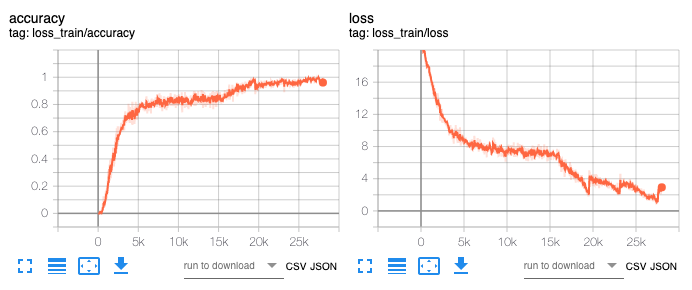

In [38]:
from PIL import Image
bn = Image.open('./cosFace/bn_curves.png')

bn

A) No batch norm

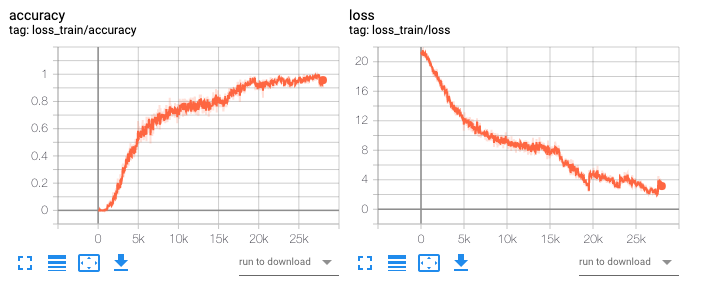

In [37]:
no_bn = Image.open('./cosFace/no_bn_curves.png')


no_bn

``Answer here.``  
A) The two are very similar in convergence and performance. The both converge quite well to a value very close to 100% accuracy (97-98%). Their loss both goes to the very similar value, but we will have to see with the lfw dataset to really see the true accuracy on a different dataset. There is one distinction however, that the no bn took quite a bit longer to get to 0.8 accuracy. It took about 15k iterations, but with bn, it took about 5k iterations. Another quite interesting observation is that both of the datasets saw a dramatic improvement around the 15k'th iteration, saW a slight upspike around the 20k'th iteration, and similar behavior thereafter. It is important to note that the loss with batch norm saw a lower minimum in loss than the network without batch norm. The reason for these occurences are explained in part C. It is enough to note that there was a sudden improvement due to the nature of Loss curves where we could have increased the learning rate here, or a certain amount of stochastic selection of the dataset's minibatches caused this phenomenon. 

 
  
B) For faceNet_BN (with batch normalization) : python lfw_eval.py --model ./checkpoint_bn/checkpoint/netFinal_8.pth --net faceNet_BN --lfw /datasets/cse152-252-sp20-public/hw2_data/lfw/
The above yielded accuracies as follows : LFWACC=0.9890 std=0.0051 thd=0.5165  

For faceNet (no batch normalization) : python lfw_eval.py --model ./checkpoint_no_bn/netFinal_8.pth --net faceNet --lfw /datasets/cse152-252-sp20-public/hw2_data/lfw/  
The above yielded : LFWACC=0.9567 std=0.0070 thd=0.2460

C) We saw a vast difference in accuracy that of close to 4%. At this order of accuracy a change of this degree leads to reasons that are other than chance. The reasoning for this can be that batch norm helps normalize the potentially high variance activations to the next input layer and therefore helps create faster training since we can use a higher learning rate due to the normalized inputs to each layer. Another aspect where this helps is through the process of normalizing (not sure if this is right word) the input data's distribution. This helps the model generalize to other input data, helping overfitting, and increasing accuracy on a test set. Finally Batch norm improves regularization which changes the minibatch values slightly different everytime. Regularization helps us reduce the need for dropout which is good since it lets us hold on to more information per layer. This decreases overfitting, and therefore both of these reasons result in a higher accuracy.  

3. If you achieve better performance compared to SphereFace in Q1, well done! Can you provide a reason? If you do not outperform SphereFace, can you provide a cause? **(10 points)**

``Answer here.``  
It did not do better than sphereface. There can be many reasons here.  
Theoretically cosface should perform better than sphereface. It offers the suggestion that not only is it important to provide a margin between the angle between classes (geometrically, in the theta space), but cosface offers the suposition that classes are not only pushed apart by a margin in the angular space, but that the margin is imposed on the cosine space as well. This creates separation where the classes join together in the angular space to be geometrically further apart. Intuitivally, this would take more training to be able to leverage this higher demanding loss function, which could also offer the explanation for the smaller accuracy that cosface offers. Since both models were run on 27k iterations, it could mean that the cosface loss function needs to learn the final steps of it's most optimal solution with more iterations. 

The following are additional potential reason that can offer towards the theoretical opposing results we found in accuracy. 
1. Initialization of the network leading to marginal accuracy differences. This suggests that since models start an arbitrary spot in the parameter space, pure luck could have caused sphereFace to perform better. Although if tested on far longer iterations until an early stopping condition was satisified would lead to this 'luck' to be overcome theoritcally through stochastic gradient descent with enough iterations. Imperically, this can be proven by running the same model several times on 27k iterations. All the models will produce slightly different accuracies, and it is imperative to run the models to their maximum optimal convergence. 
2. Loss Function Difference : Mathetmically as described above, cosface starts off with a more aggresive loss. This could prove to be harder to converge with the limited iterations. 
3. Dataset : clean data could prove to be a hindering factor. If we are being more picky with our loss function, as in the case of cosface's loss function, we could be more reliant on the authenticity and correctness of the labeled data. These small incorrect, or more diverse data could be needed to converge optimally for cosface's loss function. 

4. Randomly choose 10 identities from the CASIA dataset, forward pass all their images through the CosFace network and visualize the normalized features (embeddings) using tSNE [8]. You can use code from https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html for visualization. Try a few random samples and include the figure that you consider most illustrative of the method. **(10 points)**

In [24]:
import os
import random
from sklearn import manifold, datasets
from PIL import Image
import cosFace.faceNet as faceNet
import numpy as np
from cosFace.matlab_cp2tform import get_similarity_transform_for_PIL
import torch
from torch.autograd import Variable
import code


landMarkFile = './cosFace/data/casia_landmark.txt'
model_path = '/datasets/home/96/396/jbk001/cse152b_hw2-release/cosFace/checkpoint_bn/checkpoint/netFinal_8.pth'

def alignment(img, landmark ):
    ref_pts = [ [30.2946, 51.6963],[65.5318, 51.5014],
        [48.0252, 71.7366],[33.5493, 92.3655],[62.7299, 92.2041] ]
    crop_size = (96, 112)
    
    ref_pts = np.array(ref_pts, dtype = np.float32 ).reshape(5, 2)
    landmark = np.array(landmark).astype(np.float32).reshape(5, 2)
    
    tfm = get_similarity_transform_for_PIL(landmark, ref_pts)
    
    img = img.transform(crop_size, Image.AFFINE,
            tfm.reshape(6), resample=Image.BILINEAR)
    
    img = np.asarray(img )
    if len(img.shape ) == 2:
        img = img[:, :, np.newaxis]
        img = np.concatenate([img, img, img], axis=2)
    else:
        img = img[:, :, ::-1]

    img = np.transpose(img, [2, 0, 1] )
    return img


#get all the ids
ids = []
for idx in os.listdir('/datasets/cse152-252-sp20-public/hw2_data/CASIA-WebFace'):
    ids.append(idx)

#get random 10 ids
random_10 = random.sample(ids, 10)

#get the images for each path
random_10_images = {}
for idx, random_id in enumerate(random_10):
    random_10_images[random_id] = []
    for face in os.listdir(f'/datasets/cse152-252-sp20-public/hw2_data/CASIA-WebFace/{random_id}'):
        random_10_images[random_id].append(Image.open(f'/datasets/cse152-252-sp20-public/hw2_data/CASIA-WebFace/{random_id}/{face}'))
    
#Align all the faces
landmark = {}
with open(landMarkFile) as f:
    landmark_lines = f.readlines()
for line in landmark_lines:
    l = line.replace('\n','').split('\t')
    landmark[l[0].split('/')[0]] = [float(k) for k in l[2:] if len(k) > 0]
for identity in random_10_images:
    print(f'aligning identity : {identity}')
    for face_idx, face in enumerate(random_10_images[identity]):
        random_10_images[identity][face_idx] = (alignment(face, landmark[identity] ).astype(np.float32 ) - 127.5) / 128
    


#get the model
model = faceNet.faceNet_BN()
model.load_state_dict(torch.load(model_path))
model.cuda()
model.eval()
model.feature = True

#get the embedding of each random id
random_10_embeddings = []
class_partitions = []
count = 1
for identity in (random_10_images):
    for face in (random_10_images[identity]):
        count += 1
        #I KNOW THIS LINE OF CODE SUCKS, BUT DEAL WITH IT, IT'S 3AM RIGHT NOW BC I PLAYED TOO MUCH FIFA LAST NIGHT
        random_10_embeddings.append(model(Variable(torch.from_numpy(face.transpose(2, 0, 1).reshape((1,3,112,96))).float() ).cuda()).cpu().data.numpy())
    class_partitions.append(count)
    

embeddings = np.array(random_10_embeddings).squeeze()
np.save('embeddings.npy', embeddings)
np.save('classes.npy', class_partitions)


aligning identity : 0923210
aligning identity : 1780143
aligning identity : 4932304
aligning identity : 1119340
aligning identity : 3096939
aligning identity : 0001810
aligning identity : 1831466
aligning identity : 0162233
aligning identity : 0093697
aligning identity : 2642953


RuntimeError: Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.

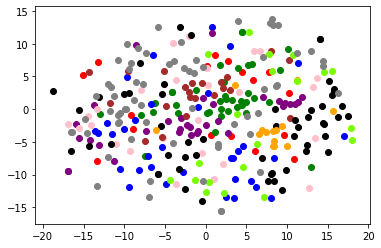

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

embeddings = np.load('embeddings.npy')
classes = np.load('classes.npy')
embeddings = TSNE(n_components=2).fit_transform(embeddings)

plot_point = {}

colors = ['red', 'green', 'blue', 'purple', 'pink', 'brown', 'black', 'orange', 'lawngreen', 'gray']
beginning = 0
for idx, identity_end in enumerate(classes):
    x = embeddings[beginning:identity_end, 0]
    y = embeddings[beginning:identity_end, 1]
    
    beginning = identity_end

    plt.scatter(x, y, color=colors[idx])
plt.show()


``Answer here.``

## Q4: Human Pose Estimation with Convolutional Pose Machines (CPM) [1]

In this question, you will be given code adapted from [PyTorch implementation of one of the CPM model [1]](https://github.com/Hzzone/pytorch-openpose), which is an follow-up work of the original Convolution Pose Machine [2], and shares the Part Confidence Maps estimation module with [2]. In this question you will be given a trained CPM model and gain insights about the model design and outputs.

- ``cd pytorch-openpose``
- Set up the environment following the instructions at ``pytorch-openpose/README.md`` (Getting Started - Install Requriements)
- Download the ``body_pose_model.pth`` from [Dropbox](https://www.dropbox.com/sh/7xbup2qsn7vvjxo/AABWFksdlgOMXR_r5v3RwKRYa?dl=0) and place under ``pytorch-openpose/model``

1. Run the inference code on the given image.

In [24]:
import os
# change your base path
os.chdir('./pytorch-openpose/')

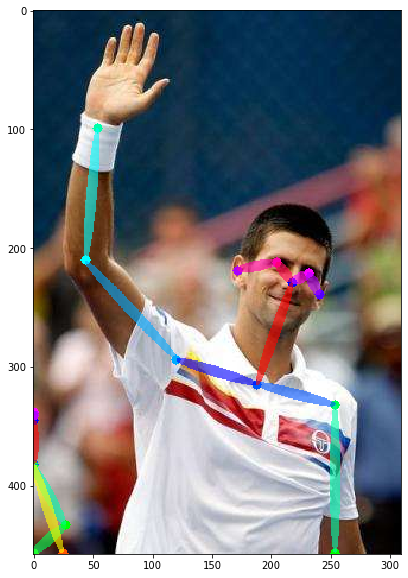

In [7]:
import cv2
import matplotlib.pyplot as plt
import copy
import numpy as np

from src import model
from src import util
from src.body import Body
from src.hand import Hand

body_estimation = Body('model/body_pose_model.pth')

test_image = 'images/demo.jpg'
oriImg = cv2.imread(test_image)  # B,G,R order
candidate, subset, heatmap_list, heatmap_list_converted_list = body_estimation(oriImg)
heatmap_0 = heatmap_list[0] 
canvas = copy.deepcopy(oriImg)
canvas = util.draw_bodypose(canvas, candidate, subset)

plt.figure(figsize=(10, 10))
plt.imshow(canvas[:, :, 
                  [2, 1, 0]])

# plt.savefig('tennis_4_1.png')
# plt.axis('off')
plt.show()


(a) Visualize the output keypoint detection result. **(5 points)**

``Paste the output figure here``

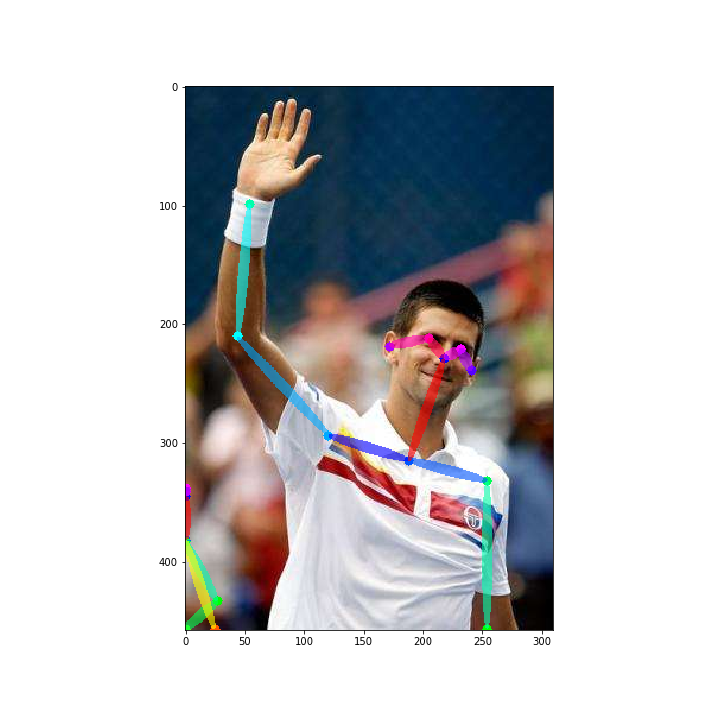

In [8]:
from PIL import Image
lol = Image.open('tennis_4_1.png')
lol

(b) What is the ratio of size $\lambda=H/H'$ between the input image **im** (Line 57 of ``body.py``) 
of shape [1, 3, H, W] and the output heatmap **heatmap_0** of shape [1, D, H', W']? **(5 points)**

``Answer the question here``  
The scale is equal to the [0.5, 1.0, 1.5, 2.0] * 368 / H. 

(c) What module in the model is reponsible for this scaling? **(5 points)**

``Answer the question here``  
cv2??

2. ``heatmap_list_converted_list[0]`` is a list of heatmaps from all 6 layers: [out1_2, out2_2, out3_2, out4_2, out5_2, out6_2], where the output of each layer is of shape [H, W, D].

This snippet gives the function to visualize the $d_{th}$ feature map from the layer **layer_idx**

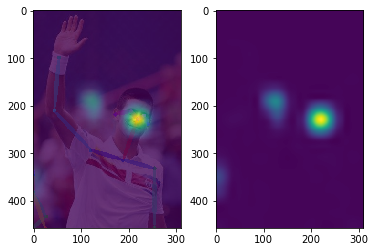

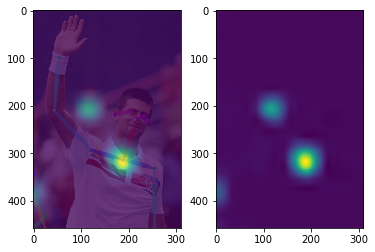

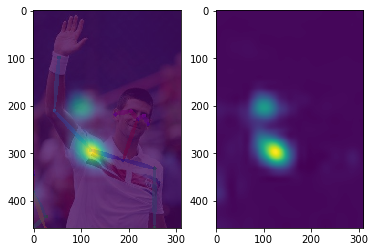

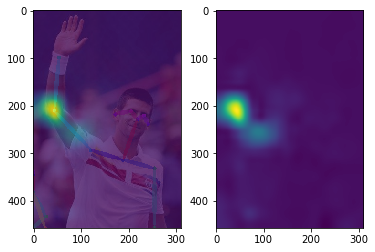

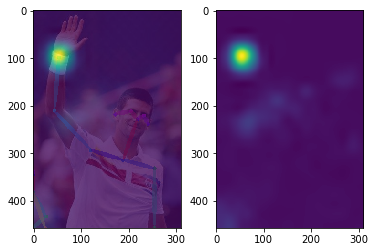

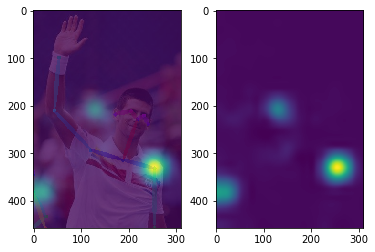

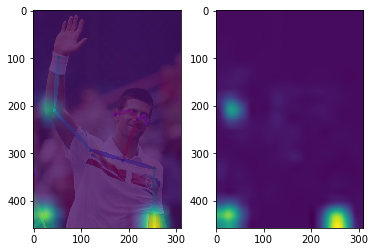

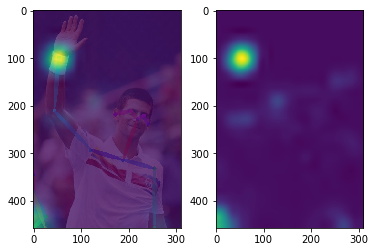

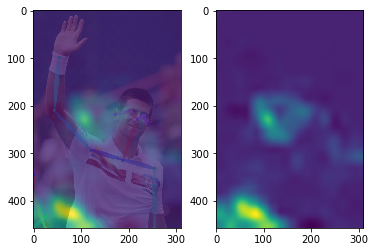

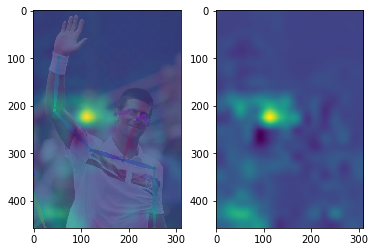

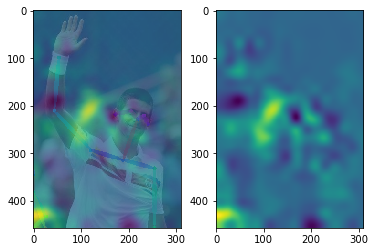

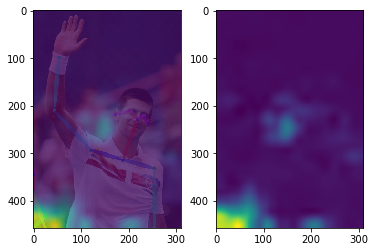

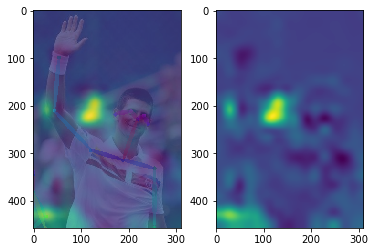

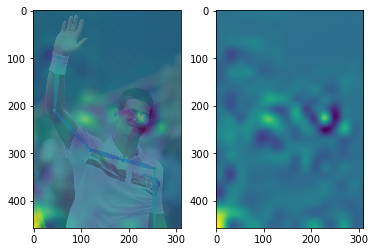

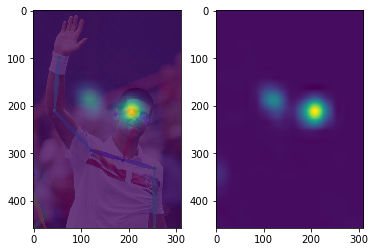

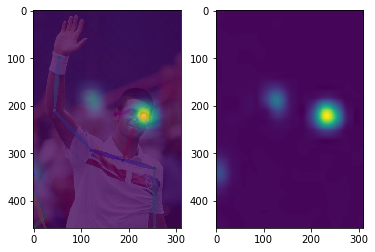

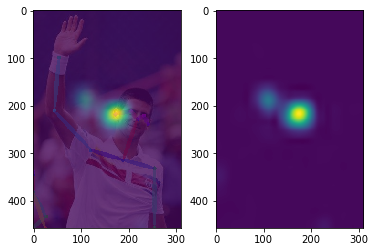

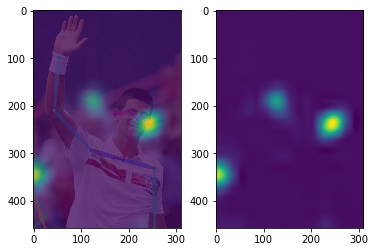

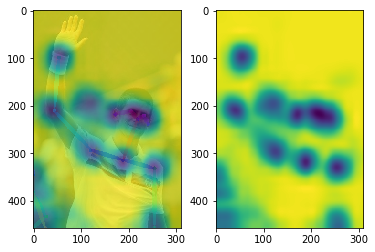

In [9]:
layer_idx = -1

for d in range(heatmap_list_converted_list[0][layer_idx].shape[2]):
    layer_idx = 0
    heatmap = heatmap_list_converted_list[0][layer_idx][:, :, d]
    util.overlay_heatmap(canvas, heatmap)

(a) What is D? And given D can you tell what is the number of keypoints that the model is trying to estimate? **(5 points)**

``Answer here``  
D is the number of joints aka keypoints that we wanted to detect, otherwise known as P often times in the slides. According to the last image we want 11 joints, also seen on the ground truth labels on the image. 

(b) Visualize and compare the heatmap from **layer_idx=0** and **layer_idx=5** for the keypoint **d=2**. **(5 points)**

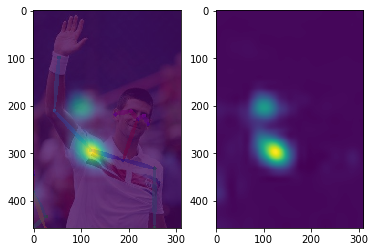

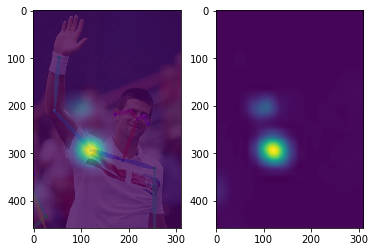

In [12]:
layer_idx_first = 0
layer_idx_second = 5
d = 2

heatmap = heatmap_list_converted_list[0][layer_idx_first][:, :, d]
util.overlay_heatmap(canvas, heatmap)

heatmap = heatmap_list_converted_list[0][layer_idx_second][:, :, d]
util.overlay_heatmap(canvas, heatmap)


``Paste and compare the visualizations here``  
From layer index 0 to 5 the confidence of the shoulder/armpit keypoint joint was stronger towards the ground truth, and it eliminated/decreased the probability towards the other false positive belief. 

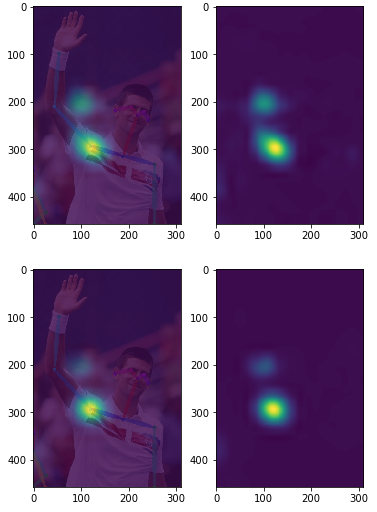

In [13]:
lol = Image.open('tennis_4_2.png')
lol

(c) Visualize and compare the heatmap from **layer_idx=0** and **layer_idx=5** for the keypoint **d=3**. **(5 points)**

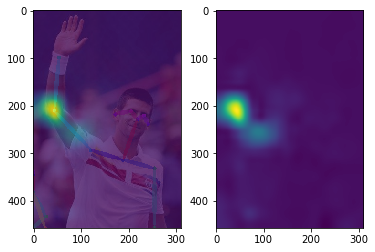

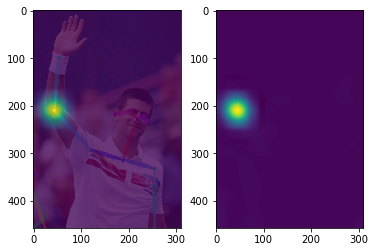

In [14]:
layer_idx_first = 0
layer_idx_second = 5
d = 3

heatmap = heatmap_list_converted_list[0][layer_idx_first][:, :, d]
util.overlay_heatmap(canvas, heatmap)

heatmap = heatmap_list_converted_list[0][layer_idx_second][:, :, d]
util.overlay_heatmap(canvas, heatmap)

``Paste and compare the visualizations here``  
In this example (similar from the previous question) the probability is greatly narrowed down towards the keypoint/joint that is right at the elbow's ground truth. Decreasing the probabililty of it being towards the faint looking heatmap at (100, 250) in the first image.

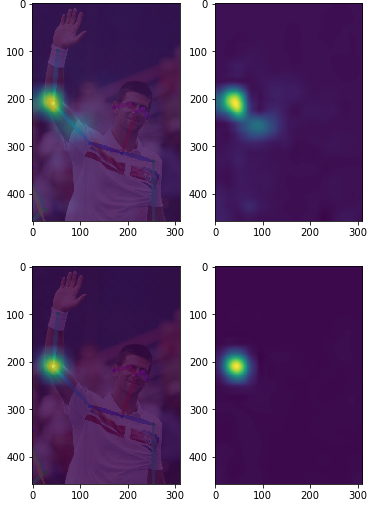

In [16]:
lol = Image.open('tennis_4_2_2.png')
lol

(d) State and justify the shared difference in these comparisons? You may get some hint from the model design. **(5 points)**

In [22]:
from src import util
from src.model import bodypose_model

model_path = './model/body_pose_model.pth'

model = bodypose_model()
if torch.cuda.is_available():
    model = model.cuda()
model_dict = util.transfer(model, torch.load(model_path))
model.load_state_dict(model_dict)
model

bodypose_model(
  (model0): Sequential(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv1_1): ReLU(inplace=True)
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv1_2): ReLU(inplace=True)
    (pool1_stage1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv2_1): ReLU(inplace=True)
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv2_2): ReLU(inplace=True)
    (pool2_stage1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv3_1): ReLU(inplace=True)
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv3_2): ReLU(inplace=True)
    (conv3_3): Conv2d(256, 256, kernel_size=

``State and justify the difference here``  
The shared difference is that they both narrowed down the heat maps closer to the ground truth. The model displayed above explains this since the stages in the latter end of the network have a larger receptive field and therefore have a larger global reasoning to infer the correct location of the keypoint/joint. The Deeper in the network that you lie, the larger RF is and therefore the more larger context you can draw from the input.  hi mom

3. Set **multi_scale=False** in Line 38 of ``body.py`` and re-run the code from Q4(1). 

    (a) Visualize the output below. **(5 points)**
    
    **NOTE: you might need to restart the kernel each time you change the ``multi_scale`` flag. This may be required to re-initialize the model. [Kernel]-->[Restart]**

``Paste figure by re-running (a) with multi_scale=False here``

(b) Do the same comparison with additional images of ``demo_coco.jpg``, ``demo_coco2.jpg``, ``demo_beach.jpg``, ``demo_ucsd.jpg``, ``demo_ucsd2.jpg``.  **(5 points)**

``For each of the additional images, paste two figures with multi_scale=True and multi_scale=False here``

(c) What shared difference can you spot in most of the comparisons? Justify the difference. **(5 points)**

``Report the difference and jsutify here``

# Reference
[1] Cao, Zhe. et al. "Realtime multi-person 2d pose estimation using part affinity fields." Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition. 2017.

[2] Wei, Shih-En. et al. "Convolutional pose machines." Proceedings of the IEEE conference on Computer Vision and Pattern Recognition. 2016.

[3] Liu, Weiyang. et al. "SphereFace: Deep Hypersphere Embedding for Face Recognition." arXiv:1704.08063.

[4] Huang, Gary. et al. "Labeled faces in the wild:  Adatabase for studying face recognition in unconstrained environments." Technical Report 07-49, Universityof Massachusetts, Amherst, October 2007.

[5] Zhang, Kaipeng. et al. "Joint face detection and alignment usingmultitask cascaded convolutional networks." IEEE Signal Processing Letters, 23(10):1499–1503, 2016.

[6] Yi, Dong. et al.  Learning face representation from scratch. arXiv:1411.7923.

[7] Wang, Hao. et al.Cosface: Large margin cosine loss for deep face recognition. In Proceedings of the IEEE Conference onComputer Vision and Pattern Recognition, pages 5265–5274, 2018.